## Programming Exercise 5: Regularized Linear Regression and Bias vs. Variance

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression

import warnings
warnings.filterwarnings('ignore')

### 1 Regularized Linear Regression

#### 1.1 Visualizing the dataset

In [2]:
datafile = 'data/ex5data1.mat'
mat = scipy.io.loadmat( datafile )
#Training set
X, y = mat['X'], mat['y']
#Cross validation set
Xval, yval = mat['Xval'], mat['yval']
#Test set
Xtest, ytest = mat['Xtest'], mat['ytest']
#Insert a column of 1's to all of the X's, as usual
X =     np.insert(X    ,0,1,axis=1)
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

In [3]:
print X.shape
print X
print y.shape

(12, 2)
[[  1.         -15.93675813]
 [  1.         -29.15297922]
 [  1.          36.18954863]
 [  1.          37.49218733]
 [  1.         -48.05882945]
 [  1.          -8.94145794]
 [  1.          15.30779289]
 [  1.         -34.70626581]
 [  1.           1.38915437]
 [  1.         -44.38375985]
 [  1.           7.01350208]
 [  1.          22.76274892]]
(12, 1)


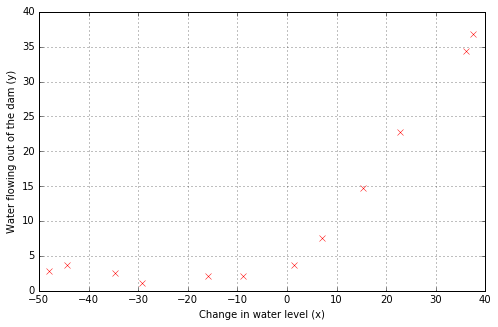

In [5]:
def plotData():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X[:,1],y,'rx')
    plt.grid(True)
    
plotData()

#### 1.2 Regularized linear regression cost function

In [6]:
def h(theta,X): #Linear hypothesis function
    return np.dot(X,theta)

def computeCost(mytheta,myX,myy,mylambda=0.): #Cost function
    """
    theta_start is an n- dimensional vector of initial theta guess
    X is matrix with n- columns and m- rows
    y is a matrix with m- rows and 1 column
    """
    m = myX.shape[0]
    myh = h(mytheta,myX)
    # print myh.shape
    #Looks like you don't really need this reshape step unless there's a 
    #more general case I'm missing. Anyway...
    myh = myh.reshape((m,1))
    # print myh.shape
    mycost = float((1./(2*m)) * np.dot((myh-myy).T,(myh-myy)))
    regterm = (float(mylambda)/(2*m)) * float(mytheta[1:].T.dot(mytheta[1:]))
    return mycost + regterm

In [7]:
# Using theta initialized at [1; 1], and lambda = 1, you should expect to 
# see an output of 303.993192
mytheta = np.array([[1.],[1.]])
print computeCost(mytheta,X,y,mylambda=1.)

303.99319222


#### 1.3 Regularized linear regression gradient

In [9]:
def computeGradient(mytheta,myX,myy,mylambda=0.):
    mytheta = mytheta.reshape((mytheta.shape[0],1))
    m = myX.shape[0]
    #grad has same shape as myTheta (2x1)
    myh = h(mytheta,myX).reshape((m,1))
    grad = (1./float(m))*myX.T.dot(h(mytheta,myX)-myy)
    regterm = (float(mylambda)/m)*mytheta
    regterm[0] = 0 #don't regulate bias term
    regterm.reshape((grad.shape[0],1))
    return grad + regterm

#Here's a wrapper for computeGradient that flattens the output
#This is for the minimization routine that wants everything flattened
def computeGradientFlattened(mytheta,myX,myy,mylambda=0.):
    return computeGradient(mytheta,myX,myy,mylambda=0.).flatten()

In [10]:
# Using theta initialized at [1; 1] you should expect to see a
# gradient of [-15.303016; 598.250744] (with lambda=1)
mytheta = np.array([[1.],[1.]])
print computeGradient(mytheta,X,y,1.)

[[ -15.30301567]
 [ 598.25074417]]


#### 1.4 Fitting linear regression

In [11]:
def optimizeTheta(myTheta_initial, myX, myy, mylambda=0.,print_output=True):
    fit_theta = scipy.optimize.fmin_cg(computeCost,x0=myTheta_initial,\
                                       fprime=computeGradientFlattened,\
                                       args=(myX,myy,mylambda),\
                                       disp=print_output,\
                                       epsilon=1.49e-12,\
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((myTheta_initial.shape[0],1))
    return fit_theta

In [12]:
mytheta = np.array([[1.],[1.]])
print mytheta.shape
fit_theta = optimizeTheta(mytheta,X,y,0.)

(2, 1)
Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


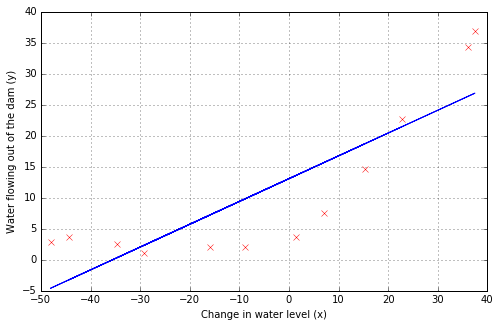

In [13]:
plotData()
plt.plot(X[:,1],h(fit_theta,X).flatten())

### 2 Bias-variance

#### 2.1 Learning curves

In [15]:
def plotLearningCurve(max):
    """
    Loop over first training point, then first 2 training points, then first 3 ...
    and use each training-set-subset to find trained parameters.
    With those parameters, compute the cost on that subset (Jtrain)
    remembering that for Jtrain, lambda = 0 (even if you are using regularization).
    Then, use the trained parameters to compute Jval on the entire validation set
    again forcing lambda = 0 even if using regularization.
    Store the computed errors, error_train and error_val and plot them.
    """
    initial_theta = np.array([[1.],[1.]])
    mym, error_train, error_val = [], [], []
    for x in xrange(1,max,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        fit_theta = optimizeTheta(initial_theta,train_subset,y_subset,mylambda=0.,print_output=False)
        error_train.append(computeCost(fit_theta,train_subset,y_subset,mylambda=0.))
        error_val.append(computeCost(fit_theta,Xval,yval,mylambda=0.))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)

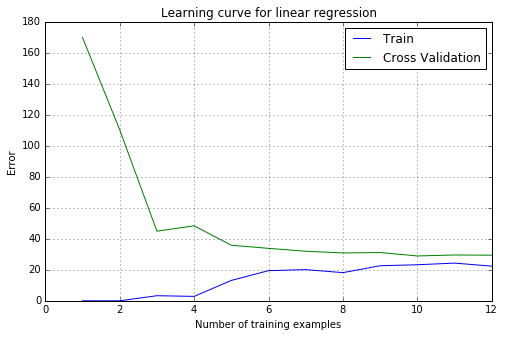

In [20]:
#"You can observe that both the train error and cross validation error are high
# when the number of training examples is increased. This reflects a high bias 
# problem in the model – the linear regression model is too simple and is unable 
# to fit our dataset well."
plotLearningCurve(13)

### 3 Polynomial regression

In [38]:
#print X.shape
# print np.power(X,0)
#dim = 3
#print np.insert(X,X.shape[1],np.power(X[:,1],dim),axis=1)
#print np.insert(X,2,np.power(X[:,1],dim),axis=1)

In [42]:
def genPolyFeatures(myX,p):
    """
    Function takes in the X matrix (with bias term already included as the first column)
    and returns an X matrix with "p" additional columns.
    The first additional column will be the 2nd column (first non-bias column) squared,
    the next additional column will be the 2nd column cubed, etc.
    """
    newX = myX.copy()
    for i in xrange(p):
        dim = i+2
        newX = np.insert(newX,newX.shape[1],np.power(newX[:,1],dim),axis=1)
    return newX

def featureNormalize(myX):
    """
    Takes as input the X array (with bias "1" first column), does
    feature normalizing on the columns (subtract mean, divide by standard deviation).
    Returns the feature-normalized X, and feature means and stds in a list
    Note this is different than my implementation in assignment 1...
    I didn't realize you should subtract the means, THEN compute std of the
    mean-subtracted columns.
    Doesn't make a huge difference, I've found
    """
   
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm,axis=0) #column-by-column
    Xnorm[:,1:] = Xnorm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(Xnorm,axis=0,ddof=1)
    Xnorm[:,1:] = Xnorm[:,1:] / stored_feature_stds[1:]
    return Xnorm, stored_feature_means, stored_feature_stds
    

#### 3.1 Learning Polynomial Regression

In [59]:
#Generate an X matrix with terms up through x^8
#(7 additional columns to the X matrix)

###############################################################
# My d=8 plot doesn't match the homework pdf, due to differences
# between scipy.optimize.fmin_cg and the octave version
# I see that in subokita's implementation, for fitting he gets the
# same results as I when using scipy.optimize.fmin_cg
# 
# The d=5 plot (up through x^6) shows overfitting clearly, so I'll
# continue using that
###############################################################

global_d = 5
newX = genPolyFeatures(X,global_d)
newX_norm, stored_means, stored_stds = featureNormalize(newX)
#Find fit parameters starting with 1's as the initial guess
mytheta = np.ones((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta,newX_norm,y,0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 302
         Function evaluations: 585
         Gradient evaluations: 585


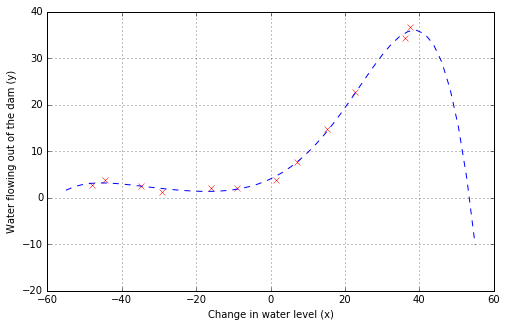

In [60]:
def plotFit(fit_theta,means,stds):
    """
    Function that takes in some learned fit values (on feature-normalized data)
    It sets x-points as a linspace, constructs an appropriate X matrix,
    un-does previous feature normalization, computes the hypothesis values,
    and plots on top of data
    """
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = np.ones((n_points_to_plot,1))
    
    xmat = np.insert(xmat,xmat.shape[1],xvals.T,axis=1)
    xmat = genPolyFeatures(xmat,len(fit_theta)-2)
    #This is undoing feature normalization
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plotData()
    plt.plot(xvals,h(fit_theta,xmat),'b--')

plotFit(fit_theta,stored_means,stored_stds)

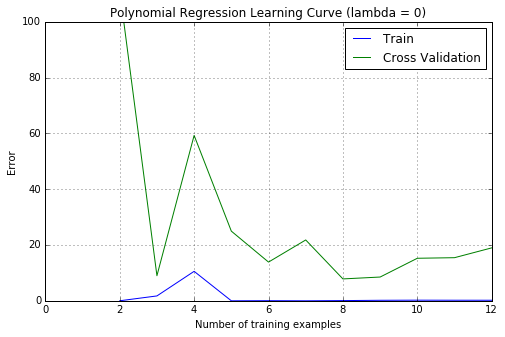

In [61]:
def plotPolyLearningCurve(mylambda=0.):

    initial_theta = np.ones((global_d+2,1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(Xval,global_d))

    for x in xrange(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset,global_d)   
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta,train_subset,y_subset,mylambda=mylambda,print_output=False)
        error_train.append(computeCost(fit_theta,train_subset,y_subset,mylambda=mylambda))
        error_val.append(computeCost(fit_theta,myXval,yval,mylambda=mylambda))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()

#### 3.2 Optional: Adjusting the regularization parameter

         Current function value: 7.828602
         Iterations: 4
         Function evaluations: 91
         Gradient evaluations: 78


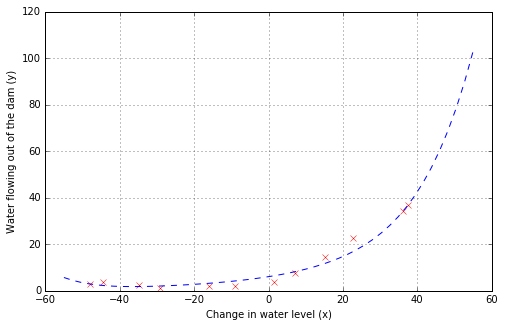

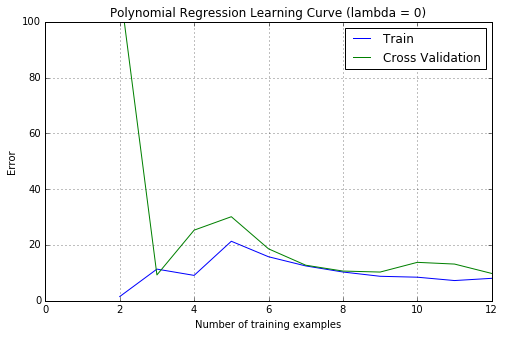

In [17]:
#Try Lambda = 1
mytheta = np.zeros((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta,newX_norm,y,1)
plotFit(fit_theta,stored_means,stored_stds)
plotPolyLearningCurve(1.)

         Current function value: 123.490836
         Iterations: 1
         Function evaluations: 56
         Gradient evaluations: 43


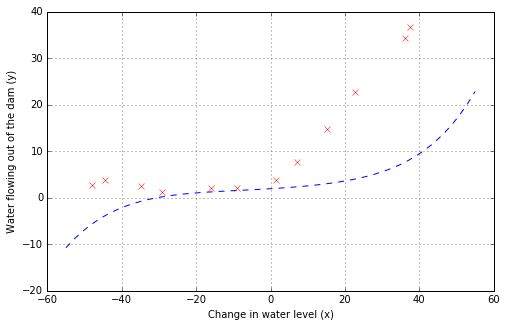

In [18]:
#Try Lambda = 100
#Note after one iteration, the lambda of 100 penalizes the theta params so hard
#that the minimizer loses precision and gives up...
#so the plot below is NOT indicative of a successful fit
mytheta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimizeTheta(mytheta,newX_norm,y,100.)
plotFit(fit_theta,stored_means,stored_stds)

#### 3.3 Selecting $\lambda$ using a cross validation set

In [19]:
#lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = genPolyFeatures(X,global_d)
    newXtrain_norm, dummy1, dummy2 = featureNormalize(newXtrain)
    newXval = genPolyFeatures(Xval,global_d)
    newXval_norm, dummy1, dummy2 = featureNormalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimizeTheta(mytheta,newXtrain_norm,y,mylambda,False)
    errors_train.append(computeCost(fit_theta,newXtrain_norm,y,mylambda=mylambda))
    errors_val.append(computeCost(fit_theta,newXval_norm,yval,mylambda=mylambda))

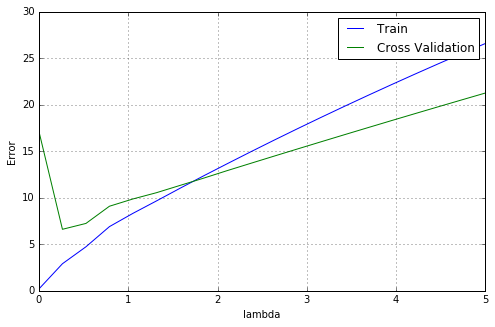

In [20]:
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)